In [2]:
%pip install tensorflow pyarrow 
%pip install pandas  
%pip install scikit-learn 
%pip install matplotlib 
%pip install requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.0/645.0 MB 17.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 50.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 50.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 49.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 56.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 160.5 MB/s eta 0:00:00
Note: you may need to restart the kernel 

In [3]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import requests
from sklearn.preprocessing import MinMaxScaler 
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout

2025-05-19 19:32:18.949989: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-19 19:32:18.951183: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-19 19:32:18.955912: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-19 19:32:18.967900: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747683138.987869     532 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747683138.99

In [4]:
np.random.seed(42)
data_length = 2000  # Adjust data length as needed
trend = np.linspace(100, 200, data_length)
noise = np.random.normal(0, 2, data_length)
synthetic_data = trend + noise

# Create a DataFrame and save as 'stock_prices.csv'
data = pd.DataFrame(synthetic_data, columns=['Close'])
data.to_csv('stock_prices.csv', index=False)
print("Synthetic stock_prices.csv created and loaded.")

Synthetic stock_prices.csv created and loaded.


In [5]:
data = pd.read_csv('stock_prices.csv') 
data = data[['Close']].values

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

In [6]:
def create_dataset(data, time_step=1):
    X, Y = [], []

    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [7]:
time_step = 100
X, Y = create_dataset(data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)


print("Shape of X:", X.shape) 
print("Shape of Y:", Y.shape)

Shape of X: (1899, 100, 1)
Shape of Y: (1899,)


### Defining the Multi-Head Self-Attention Mechanism

In [8]:
import tensorflow as tf 
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout 

class MultiHeadSelfAttention(Layer): 
    def __init__(self, embed_dim, num_heads=8): 
        super(MultiHeadSelfAttention, self).__init__() 
        self.embed_dim = embed_dim 
        self.num_heads = num_heads 
        self.projection_dim = embed_dim // num_heads 
        self.query_dense = Dense(embed_dim) 
        self.key_dense = Dense(embed_dim) 
        self.value_dense = Dense(embed_dim) 
        self.combine_heads = Dense(embed_dim) 
 

    def attention(self, query, key, value): 
        score = tf.matmul(query, key, transpose_b=True) 
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32) 
        scaled_score = score / tf.math.sqrt(dim_key) 
        weights = tf.nn.softmax(scaled_score, axis=-1) 
        output = tf.matmul(weights, value) 
        return output, weights 


    def split_heads(self, x, batch_size): 
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim)) 
        return tf.transpose(x, perm=[0, 2, 1, 3]) 


    def call(self, inputs): 
        batch_size = tf.shape(inputs)[0] 
        query = self.query_dense(inputs) 
        key = self.key_dense(inputs) 
        value = self.value_dense(inputs) 
        query = self.split_heads(query, batch_size) 
        key = self.split_heads(key, batch_size) 
        value = self.split_heads(value, batch_size) 
        attention, _ = self.attention(query, key, value) 
        attention = tf.transpose(attention, perm=[0, 2, 1, 3]) 
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim)) 
        output = self.combine_heads(concat_attention) 
        return output 

class TransformerBlock(Layer): 
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(TransformerBlock, self).__init__() 
        self.att = MultiHeadSelfAttention(embed_dim, num_heads) 
        self.ffn = tf.keras.Sequential([ 
            Dense(ff_dim, activation="relu"), 
            Dense(embed_dim), 
        ]) 

        self.layernorm1 = LayerNormalization(epsilon=1e-6) 
        self.layernorm2 = LayerNormalization(epsilon=1e-6) 
        self.dropout1 = Dropout(rate) 
        self.dropout2 = Dropout(rate) 
 

    def call(self, inputs, training): 
        attn_output = self.att(inputs) 
        attn_output = self.dropout1(attn_output, training=training) 
        out1 = self.layernorm1(inputs + attn_output) 
        ffn_output = self.ffn(out1) 
        ffn_output = self.dropout2(ffn_output, training=training) 
        return self.layernorm2(out1 + ffn_output) 

class TransformerEncoder(Layer): 
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(TransformerEncoder, self).__init__() 
        self.num_layers = num_layers 
        self.embed_dim = embed_dim 
        self.enc_layers = [TransformerBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)] 
        self.dropout = Dropout(rate) 

    def call(self, inputs, training=False): 
        x = inputs 
        for i in range(self.num_layers): 
            x = self.enc_layers[i](x, training=training) 
        return x 

# Example usage 
embed_dim = 128 
num_heads = 8 
ff_dim = 512 
num_layers = 4 

transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim) 
inputs = tf.random.uniform((1, 100, embed_dim)) 
outputs = transformer_encoder(inputs, training=False)  # Use keyword argument for 'training' 
print(outputs.shape)  # Should print (1, 100, 128) 

2025-05-19 19:32:22.763693: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


(1, 100, 128)


In [9]:
embed_dim = 128 
num_heads = 8 
ff_dim = 512 
num_layers = 4 

transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim) 

input_shape = (X.shape[1], X.shape[2]) 
inputs = tf.keras.Input(shape=input_shape) 

x = tf.keras.layers.Dense(embed_dim)(inputs) 
encoder_outputs = transformer_encoder(x) 
flatten = tf.keras.layers.Flatten()(encoder_outputs) 
outputs = tf.keras.layers.Dense(1)(flatten) 
model = tf.keras.Model(inputs, outputs) 

model.compile(optimizer='adam', loss='mse') 
model.summary() 

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 100, 128)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ (None, 100, 128)       │       793,088 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │        12,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 806,145 (3.08 MB)

 Trainable params: 806,145 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.fit(X, Y, epochs=20, batch_size=32)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 70s 974ms/step - loss: 12.6937
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 57s 951ms/step - loss: 0.2025
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 58s 958ms/step - loss: 0.1770 
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 58s 963ms/step - loss: 0.1692
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 58s 971ms/step - loss: 0.1555
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 58s 975ms/step - loss: 0.1329
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 57s 956ms/step - loss: 0.1502
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 59s 979ms/step - loss: 0.1146
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 59s 981ms/step - loss: 0.1332
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 59s 977ms/step - loss: 0.1433
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 59s 991ms/step - loss: 0.1203
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - loss: 0.1013   
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - loss: 0.0758 
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - loss: 0.0898 
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s

60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 314ms/step


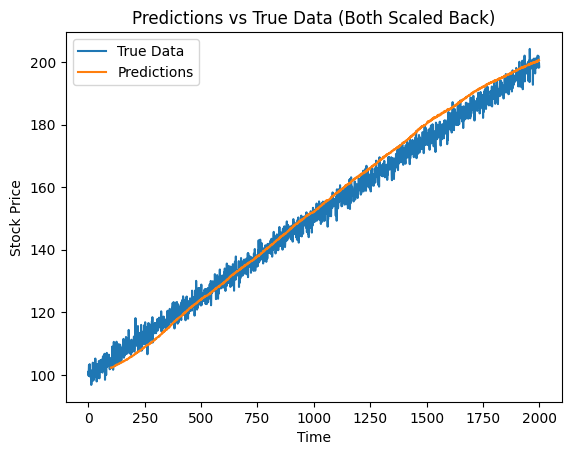

In [11]:
predictions = model.predict(X) 
predictions = scaler.inverse_transform(predictions) 

true_values = scaler.inverse_transform(data.reshape(-1, 1))

import matplotlib.pyplot as plt 
plt.plot(true_values, label='True Data') 
plt.plot(np.arange(time_step, time_step + len(predictions)), predictions, label='Predictions') 
plt.xlabel('Time') 
plt.ylabel('Stock Price') 
plt.legend() 
plt.title('Predictions vs True Data (Both Scaled Back)')
plt.show() 

In [12]:
transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim) 

input_shape = (X.shape[1], X.shape[2]) 
inputs = tf.keras.Input(shape=input_shape) 
x = tf.keras.layers.Dense(embed_dim)(inputs) 
encoder_outputs = transformer_encoder(x) 
flatten = tf.keras.layers.Flatten()(encoder_outputs) 
dropout = Dropout(0.5)(flatten) 
outputs = tf.keras.layers.Dense(1)(dropout) 

model = tf.keras.Model(inputs, outputs) 
model.compile(optimizer='adam', loss='mse')   
model.fit(X, Y, epochs=20, batch_size=32) 

loss = model.evaluate(X, Y) 
print(f'Test loss: {loss}') 

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - loss: 12.0422 
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 58s 968ms/step - loss: 2.0097
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 58s 975ms/step - loss: 1.5721
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 58s 969ms/step - loss: 1.0494
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 58s 963ms/step - loss: 0.4248
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 58s 973ms/step - loss: 0.2125
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 58s 960ms/step - loss: 0.0742
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 84s 998ms/step - loss: 0.0407
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - loss: 0.0299   
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - loss: 0.0282 
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - loss: 0.0254 
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - loss: 0.0219 
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - loss: 0.0197 
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - loss: 0.0230 
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - l

In [13]:
model.fit(X, Y, epochs=20, batch_size=16)
loss = model.evaluate(X, Y)
print(f'Test loss with batch size 16: {loss}')

model.fit(X, Y, epochs=20, batch_size=64)
loss = model.evaluate(X, Y)
print(f'Test loss with batch size 64: {loss}')

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 73s 616ms/step - loss: 0.0207 
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 73s 617ms/step - loss: 0.0500 
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 73s 615ms/step - loss: 0.0251 
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 73s 611ms/step - loss: 0.0305 
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 73s 611ms/step - loss: 0.0215 
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 73s 614ms/step - loss: 0.0218 
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 73s 613ms/step - loss: 0.0204 
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 73s 616ms/step - loss: 0.0246 
Epoch 9/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 73s 613ms/step - loss: 0.0188 
Epoch 10/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 73s 614ms/step - loss: 0.0174 
Epoch 11/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 74s 618ms/step - loss: 0.0223 
Epoch 12/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 73s 615ms/step - loss: 0.0145 
Epoch 13/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 73s 614ms/step - loss: 0.0152 
Epoch 14/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 73s 615ms/step - loss: 0.0139 
E

In [14]:
outputs = tf.keras.layers.Dense(1, activation='tanh')(flatten)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='mse')
model.fit(X, Y, epochs=20, batch_size=32)
loss = model.evaluate(X, Y)
print(f'Test loss with tanh activation: {loss}')

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - loss: 0.1202 
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - loss: 0.0103 
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - loss: 0.0072   
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - loss: 0.0065 
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - loss: 0.0049 
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - loss: 0.0035
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - loss: 0.0041 
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - loss: 0.0026 
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - loss: 0.0025 
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - loss: 0.0033 
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - loss: 0.0021 
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - loss: 0.0048
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - loss: 0.0033 
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - loss: 0.0022 
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - loss: 0.0026 
Epoc